# Natural Language Processing & Machine Learning

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf

In [2]:
%matplotlib notebook

In [3]:
# Get the dataset from here: https://www.kaggle.com/uciml/sms-spam-collection-dataset

df = pd.read_csv("data/spam.csv", names=['status', 'message', 'crap1', 'crap2', 'crap3'], 
                 header=None, skiprows=[0], encoding='latin-1')

In [4]:
df.head()

,status,message,crap1,crap2,crap3
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Let's see how the csv looks like on the others fields
df_tmp = df[df['crap1'].notnull() | df['crap2'].notnull() | df['crap3'].notnull()]
df_tmp.size

250

In [6]:
# Let's see if we can discard those rows:
df.size, df_tmp.size, df_tmp.size/df.size

(27860, 250, 0.008973438621679828)

In [7]:
# Let's remove the rows of df_tmp from df
df = df.drop(df_tmp.index)
df.size

27610

In [8]:
# Just leave status and message!
df = df.drop(columns=['crap1', 'crap2', 'crap3'])
df.head()

,status,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# If you just installed nltk don't forget this:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
    

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [10]:
# Let's do some NLP to the message"

stemmer = SnowballStemmer('english')

def process_text(text):
    '''
    Thanks:
    https://stackoverflow.com/questions/45670532/stemming-words-with-nltk-python
    '''
    # Remove non-letters, but don't remove whitespaces just yet. You can also simplify your regex a bit.
    letters_only = re.sub("[^\w\s]", " ", text) 

    # Convert to lower case, split into individual words: I recommend using word_tokenize again, here.
    words = word_tokenize(letters_only.lower())                  

    # Remove stop words.
    stops = set(stopwords.words("english")) 
    meaningful_words = [w for w in words if not w in stops]
    
    # Stem words. Here is another issue. Stem meaningful_words, not words.
    return ' '.join([stemmer.stem(w) for w in meaningful_words])

In [11]:
# An example of what the function above does:
print("Before:", df['message'][0])
print("After :", process_text(df['message'][0]))

Before: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
After : go jurong point crazi avail bugi n great world la e buffet cine got amor wat


In [12]:
# spam/ham as a number!
df['status_int'] = df['status'].apply(lambda x: 1.0 if x == "ham" else 0.0)

In [13]:
%%time
df['message_processed'] = df['message'].apply(process_text)

CPU times: user 2.37 s, sys: 218 ms, total: 2.59 s
Wall time: 2.59 s


In [14]:
df.head(10)

,status,message,status_int,message_processed
0,ham,"Go until jurong point, crazy.. Available only ...",1.0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,1.0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.0,free entri 2 wkli comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,1.0,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",1.0,nah think goe usf live around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,0.0,freemsg hey darl 3 week word back like fun sti...
6,ham,Even my brother is not like to speak with me. ...,1.0,even brother like speak treat like aid patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,1.0,per request mell mell oru minnaminungint nurun...
8,spam,WINNER!! As a valued network customer you have...,0.0,winner valu network custom select receivea å 9...
9,spam,Had your mobile 11 months or more? U R entitle...,0.0,mobil 11 month u r entitl updat latest colour ...


In [15]:
%%time
# pandas apply is very slow!!! Let's build it it parallel
from multiprocessing import Pool, cpu_count

def apply_process_text_parallel(data):
    data['message_processed_parallel'] = data['message'].apply(process_text)
    return data
    
n_threads = cpu_count()
n_partitions = n_threads * 3

pool = Pool(n_threads)

df_split = np.array_split(df, n_threads)
df = pd.concat(pool.map(apply_process_text_parallel, df_split))

pool.close()
pool.join()


CPU times: user 37 ms, sys: 36.6 ms, total: 73.6 ms
Wall time: 768 ms


In [16]:
# Just to make sure I did not mess up
assert df['message_processed'].equals(df['message_processed_parallel']) == True

In [17]:
df.head(10)

,status,message,status_int,message_processed,message_processed_parallel
0,ham,"Go until jurong point, crazy.. Available only ...",1.0,go jurong point crazi avail bugi n great world...,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,1.0,ok lar joke wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.0,free entri 2 wkli comp win fa cup final tkts 2...,free entri 2 wkli comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,1.0,u dun say earli hor u c alreadi say,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",1.0,nah think goe usf live around though,nah think goe usf live around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,0.0,freemsg hey darl 3 week word back like fun sti...,freemsg hey darl 3 week word back like fun sti...
6,ham,Even my brother is not like to speak with me. ...,1.0,even brother like speak treat like aid patent,even brother like speak treat like aid patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,1.0,per request mell mell oru minnaminungint nurun...,per request mell mell oru minnaminungint nurun...
8,spam,WINNER!! As a valued network customer you have...,0.0,winner valu network custom select receivea å 9...,winner valu network custom select receivea å 9...
9,spam,Had your mobile 11 months or more? U R entitle...,0.0,mobil 11 month u r entitl updat latest colour ...,mobil 11 month u r entitl updat latest colour ...


In [18]:
# First let's understand what are the SKLearn Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
# Let's select a few messages
messages = df['message'][[0,1,3]].tolist()
# transform text in messages into ocurrences of feature_names. See below
messages_cv = cv.fit_transform(messages)

print(20*'-', "messages raw", 20*'-')
pprint(messages)
print(20*'-', "messages as count vectoriser: ocurrences in features", 20*'-')
pprint(messages_cv.toarray())
print(20*'-', "feature names", 20*'-')
pprint(cv.get_feature_names())
print(20*'-', "Inverse transform for the first message", 20*'-')
cv.inverse_transform(messages_cv[0])

-------------------- messages raw --------------------
['Go until jurong point, crazy.. Available only in bugis n great world la e '
 'buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 'U dun say so early hor... U c already then say...']
-------------------- messages as count vectoriser: ocurrences in features --------------------
array([[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 0, 0, 0, 0, 0]], dtype=int64)
-------------------- feature names --------------------
['already',
 'amore',
 'available',
 'buffet',
 'bugis',
 'cine',
 'crazy',
 'dun',
 'early',
 'go',
 'got',
 'great',
 'hor',
 'in',
 'joking',
 'jurong',
 'la',
 'lar',
 'ok',
 'oni',
 'only',
 'point',
 'say',
 'so',
 'then',
 'there',
 'until',
 '

[array(['wat', 'amore', 'got', 'there', 'cine', 'buffet', 'la', 'world',
        'great', 'bugis', 'in', 'only', 'available', 'crazy', 'point',
        'jurong', 'until', 'go'], dtype='<U9')]

TFIDF (term frequency - inverse document frequency) is a statistical method to tell how important a word is to a particular document by increasing the numerical value for an occurrence in the specific document but decreasing relative to number of occurrences in the entire corpus.


In [19]:
vectorizer = TfidfVectorizer("english")
messages_processed = df['message_processed'].tolist()
features = vectorizer.fit_transform(messages_processed)

# Let's split the dataset into train and test
features_train, features_test, labels_train, labels_test = train_test_split(
    features, df['status_int'], test_size=0.25, random_state=123
)

# Machine learning

##  C-Support Vector Classification

<IPython.core.display.Javascript object>


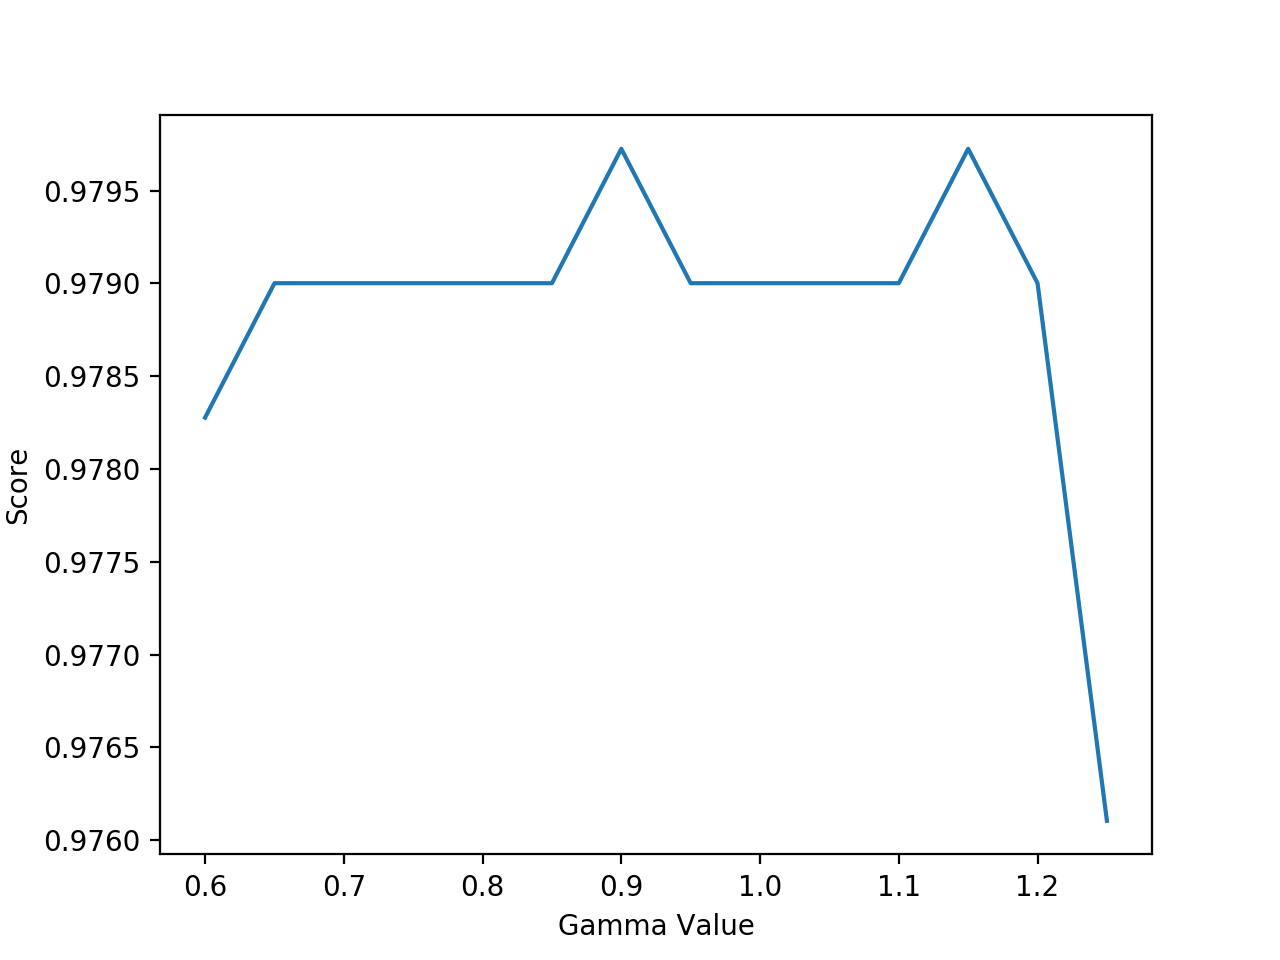

**** The best gamma value is 0.9 with a score of 0.98.


In [20]:
gammas = np.arange(0.6,1.3,0.05)
scores = []

for gamma in gammas:
    svc = SVC(kernel='sigmoid', gamma=gamma)
    svc.fit(features_train, labels_train)
    prediction = svc.predict(features_test)
    score = accuracy_score(labels_test, prediction)
    scores.append(score)

plt.figure()
plt.plot(gammas,scores)
plt.xlabel("Gamma Value")
plt.ylabel("Score")

print("**** The best gamma value is {:.3} with a score of {:.3}.".format(
    gammas[np.argmax(scores)], np.max(scores)))

# Multinomial Naive Bayes Model

<IPython.core.display.Javascript object>


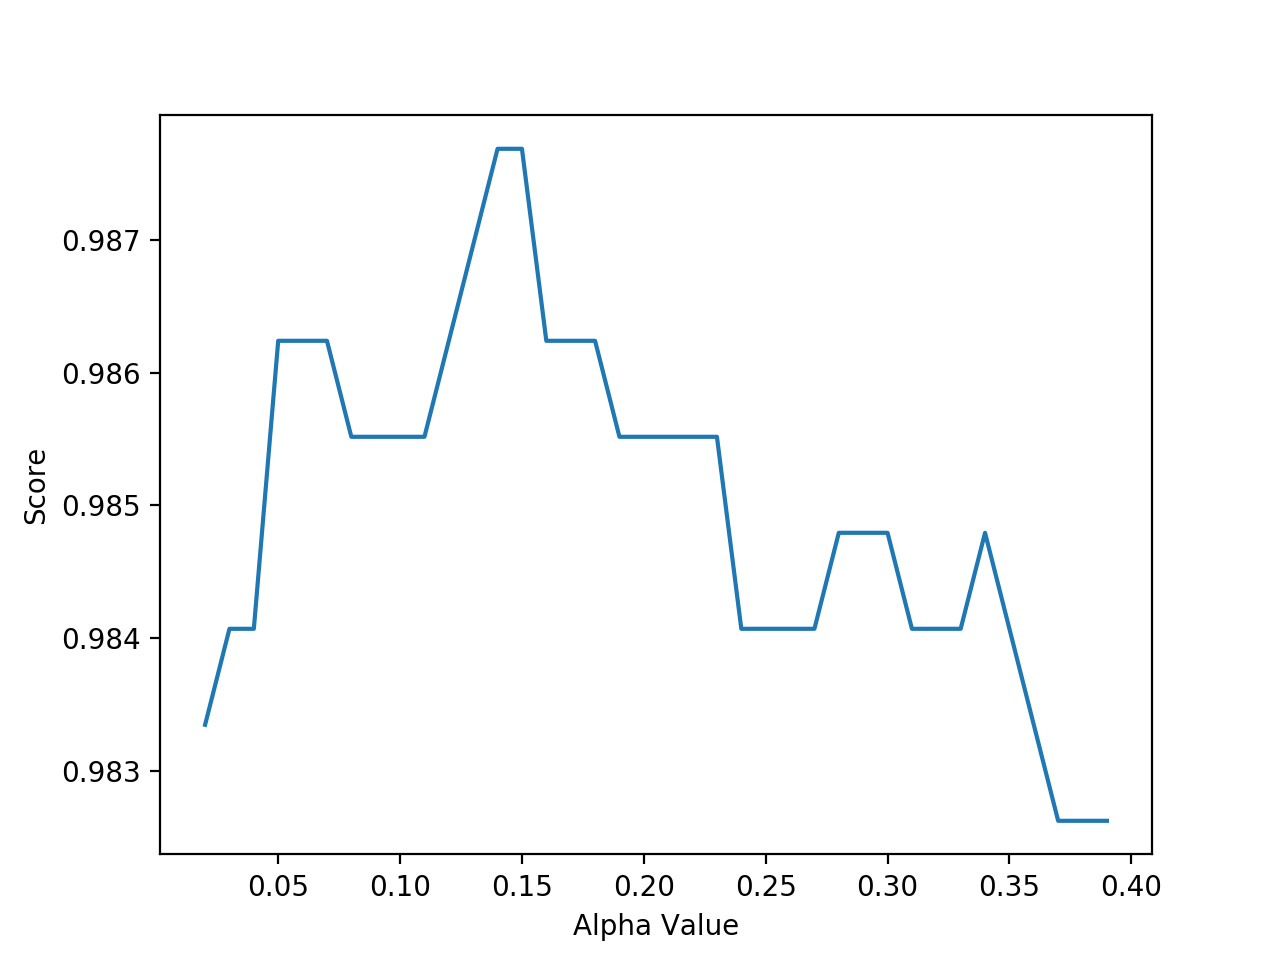

**** The best alpha value is 0.14 with a score of 0.988.


In [21]:
alphas = np.arange(0.02,0.4,0.01)
scores = []

for alpha in alphas:
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(features_train, labels_train)
    prediction = mnb.predict(features_test)
    score = accuracy_score(labels_test, prediction)
    scores.append(score)

plt.figure()
plt.plot(alphas, scores)
plt.xlabel("Alpha Value")
plt.ylabel("Score")

print("**** The best alpha value is {:.3} with a score of {:.3}.".format(
    alphas[np.argmax(scores)], np.max(scores)))

## Neural Network (Keras)

In [22]:
features_train.shape, features_test.shape, features_train.shape[1]

((4141, 7135), (1381, 7135), 7135)

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

epochs=10
batch_size=10

# Model
model = Sequential()
model.add(Dense(round(features_train.shape[1]/10), input_dim=features_train.shape[1], activation='relu'))
model.add(Dense(round(features_train.shape[1]/4), activation='relu'))
#model.add(Dense(int(features_train.shape[1]/4), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(features_train, labels_train, epochs=epochs, batch_size=batch_size)

predictions = model.predict(features_test)
# Because we use a sigmoid at the end and it gives a probability between 0 and 1
# Round it to the closest integer
rounded = [round(x[0]) for x in predictions]

score = accuracy_score(labels_test, rounded)
print("\n***** Final score of {:.3}.".format(score))

Epoch 1/10
4141/4141 [==============================] - 23s 6ms/step - loss: 0.1423 - acc: 0.9507
Epoch 2/10
4141/4141 [==============================] - 22s 5ms/step - loss: 0.0165 - acc: 0.9949
Epoch 3/10
4141/4141 [==============================] - 22s 5ms/step - loss: 0.0021 - acc: 0.9995
Epoch 4/10
4141/4141 [==============================] - 23s 5ms/step - loss: 1.9456e-04 - acc: 1.0000
Epoch 5/10
4141/4141 [==============================] - 23s 5ms/step - loss: 4.8409e-05 - acc: 1.0000
Epoch 6/10
4141/4141 [==============================] - 23s 5ms/step - loss: 2.4220e-05 - acc: 1.0000
Epoch 7/10
4141/4141 [==============================] - 23s 6ms/step - loss: 1.4132e-05 - acc: 1.0000
Epoch 8/10
4141/4141 [==============================] - 23s 5ms/step - loss: 8.8287e-06 - acc: 1.0000
Epoch 9/10
4141/4141 [==============================] - 23s 6ms/step - loss: 5.9126e-06 - acc: 1.0000
Epoch 10/10
4141/4141 [==============================] - 23s 6ms/step - loss: 3.9956e-06 - acc

In [26]:
# list all data in history
history.history.keys()

dict_keys(['loss', 'acc'])

<IPython.core.display.Javascript object>


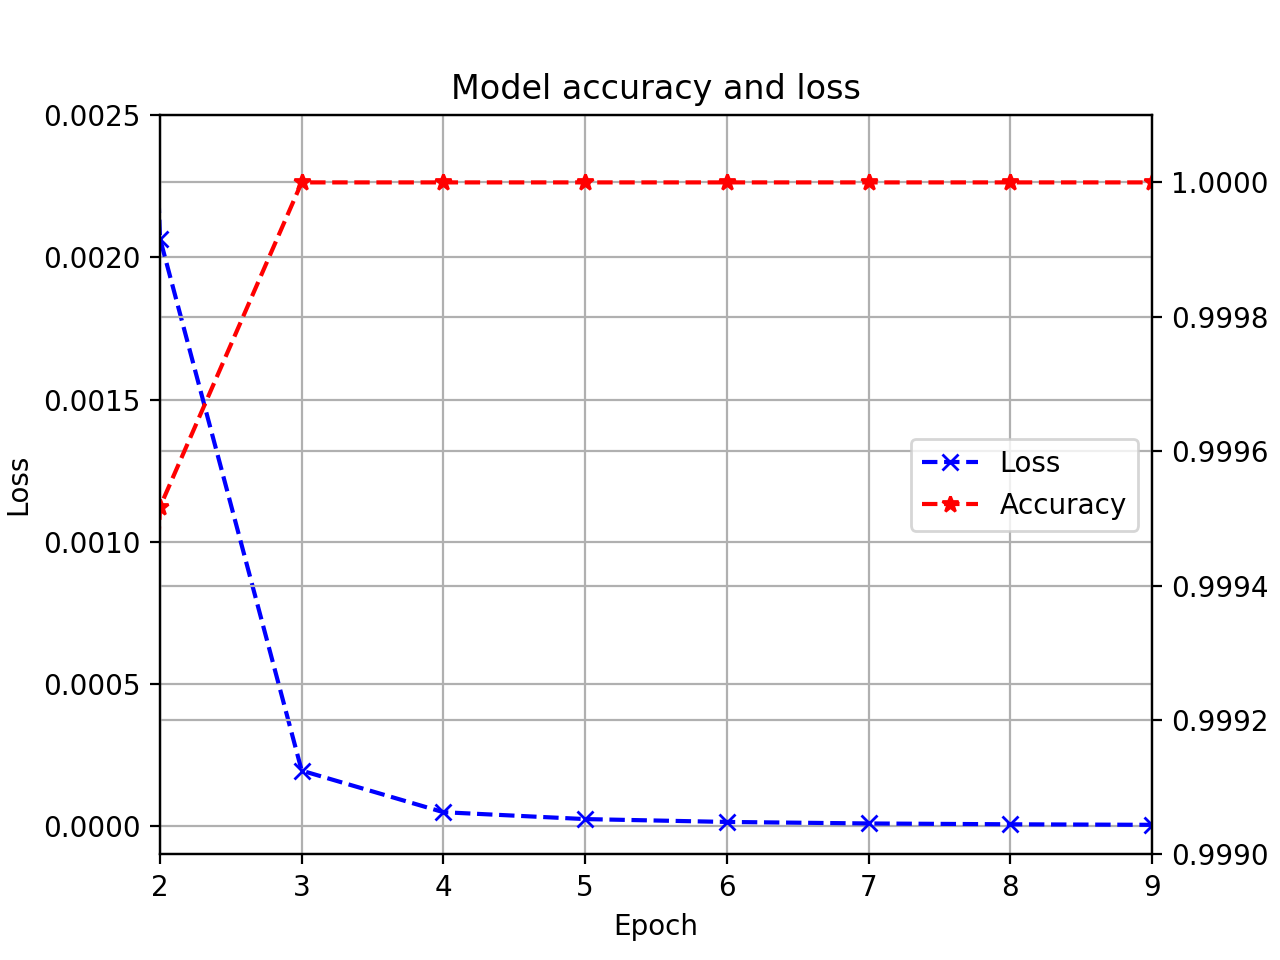

In [46]:
fig, ax1 = plt.subplots()

ax1.plot(history.history['loss'], 'bx--', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.set_xlim(left=2, right=9)
ax1.set_ylim(bottom=-0.0001, top=0.0025)
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(history.history['acc'], 'r*--', label='Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(bottom=0.9990, top=1.0001)
ax2.grid()

plt.title('Model accuracy and loss')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='center right')
